In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [14]:
import numpy as np
import pandas as pd

In [15]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [17]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [74]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables

In [75]:
#reflect the tables
engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [76]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [77]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [78]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

- Design a query to retrieve the last 12 months of precipitation data and plot the results
- Calculate the date 1 year ago from the last data point in the database
- Perform a query to retrieve the data and precipitation scores
- Save the query results as a Pandas DataFrame and set the index to the date column
- Sort the dataframe by date
- Use Pandas Plotting with Matplotlib to plot the data


In [79]:
# Calculate the date 1 year ago from the last data point in the database
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [70]:
# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > '2016-08-23').all()


# Load the results into a pandas dataframe. Set the index to the date column
prcp_df = pd.DataFrame(results).set_index('date')
prcp_df = prcp_df.sort_values(by = 'date').dropna()
prcp_df

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
...,...
2017-08-22,0.00
2017-08-23,0.08
2017-08-23,0.00


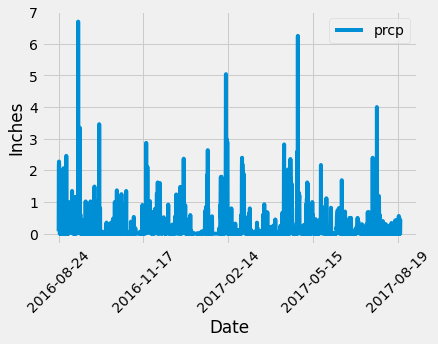

In [91]:
#Plot the data using Pandas Matplotlib
prcp_df.plot(rot = 45)
plt.xlabel("Date")
plt.ylabel("Inches")

plt.savefig("12 mnth prcp.png")

plt.show()

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [86]:
# Design a query to show how many stations are available in this dataset?
session.query(station.station).count() 


9

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.date)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [50]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(measurement.station, func.max(measurement.tobs), func.min(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == 'USC00519281').\
    group_by(measurement.station).all()
    

[('USC00519281', 85.0, 54.0, 71.66378066378067)]

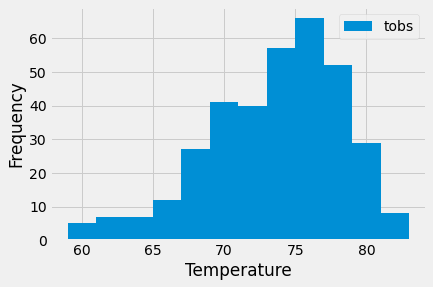

In [87]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date > '2016-08-23').\
    filter(measurement.station == 'USC00519281').all()

#convert to dataframe
temp_results_df = pd.DataFrame(temp_results)

#create histogram
temp_results_df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')

plt.show()



## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
